### References:
- [Kaggle dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?datasetId=576013&sortBy=voteCount)
- Some code is borrowed from this [notebook](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [210]:
import os
import time
import copy
from random import shuffle

import cv2
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt

In [220]:
from pathlib import Path


DATA_PATH = Path('./COVID-19_Radiography_Dataset_v2//')
classes_path = list(f for f in DATA_PATH.glob('*') if f.is_dir())
classes_path

[WindowsPath('COVID-19_Radiography_Dataset_v2/covid'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/lung_opacity'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/normal'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/viral_pneumonia')]

In [221]:
covid_paths = list(COVID_PATH.glob('images/*.png'))
normal_paths = list(NORMAL_PATH.glob('images/*.png'))

val_pct = 0.95
train_paths = []
val_paths = []

with open(DATA_PATH / 'train.csv', 'w') as tr, open(DATA_PATH / 'val.csv', 'w') as val:
    for cp in classes_path:
        paths = list(cp.glob('images/*.png'))
        num_val = int(len(paths) * val_pct)
        tr.write('\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[:-num_val]) + '\n')
        val.write('\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[-num_val:]) + '\n')

#     for c, paths in zip(('covid', 'normal'), (covid_paths, normal_paths)):
        

{'covid': 3616, 'lung_opacity': 6012, 'normal': 10192, 'viral_pneumonia': 1345}


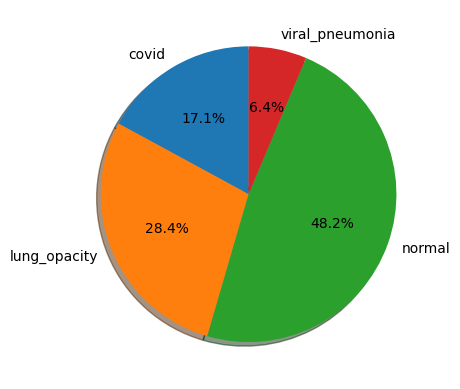

In [222]:
image_count = {}
for c in DATA_PATH.glob('*'):
    if c.is_file():
        continue
    image_count[c.name] = sum(1 for _ in (c / 'images').glob('*'))

    
print(image_count)
#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

I have taken correct propositions of data from each classes while staging my data to avoid overfitted results. Medical Image Datasets will always be like this, we don't have enough data on victim rather we have so many healthy ones. That is what we called is a "Skewed Dataset", obviously we developed methods to approach those problems (like K-Fold Cross Validation) that will explain that in my next notebook.

Lets view some images to know what we are dealing with here. Feel free the run the cell to view images at random from the repository.

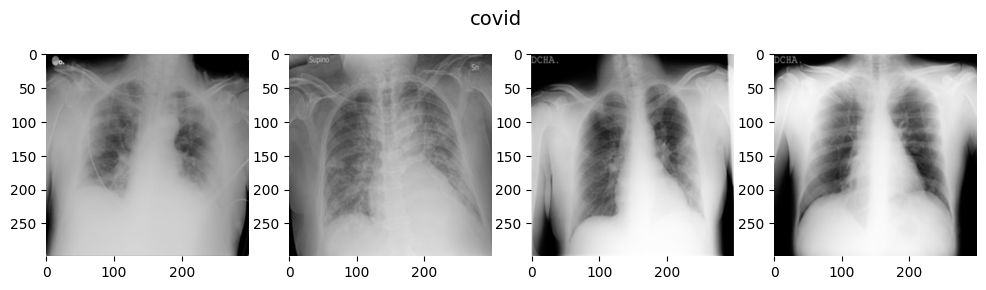

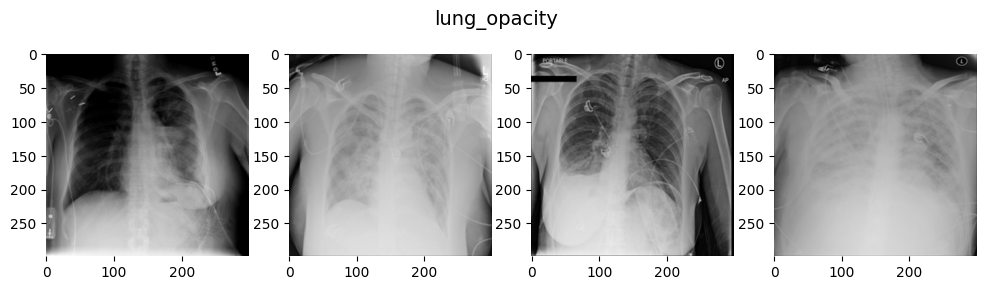

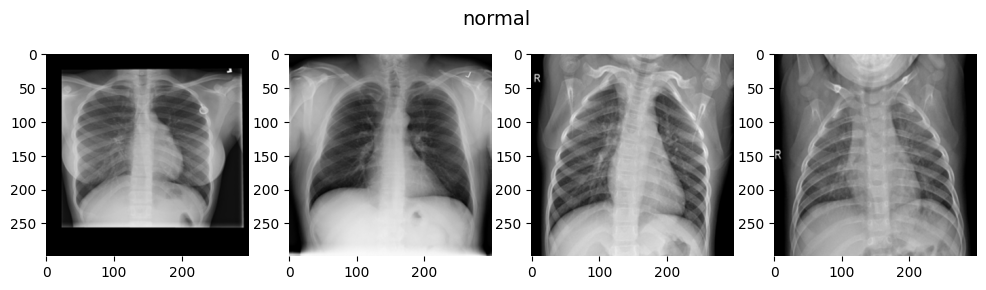

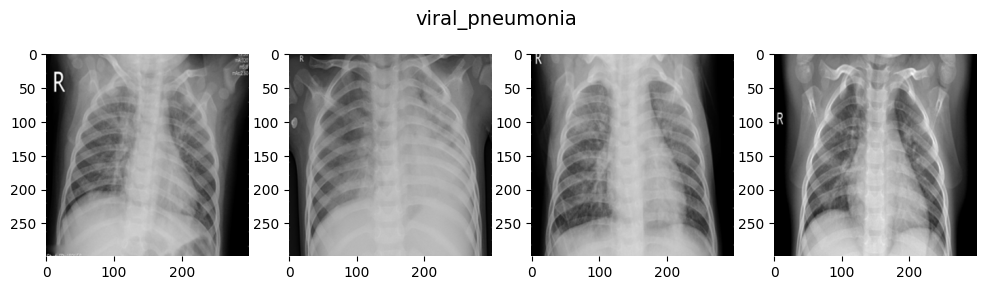

In [238]:
for cp in classes_path:
    fig = plt.figure(figsize=(12, 3))
    fig.suptitle(cp.name, size=14)

    for i, image in enumerate((cp / 'images').glob('*')):
        img = cv2.imread(str(image))
        plt.subplot(1,4, i+1, frameon=False)
        plt.imshow(img)
        if i == 3: break

In [240]:
imagenet_mean = 0.485, 0.456, 0.406
imagenet_std = 0.229, 0.224, 0.225
grayscale_coefs = 0.2989, 0.587, 0.114

grayscale_mean = sum(m*c for m, c in zip(imagenet_mean, grayscale_coefs))
grayscale_std = sum(m*c for m, c in zip(imagenet_std, grayscale_coefs))
# grayscale, mean_nums, std_nums
grayscale_mean, grayscale_std


(0.4589225, 0.2255861)

In [241]:
import albumentations as albu


# imagenet norm stats converted to grayscale 
mean = [grayscale_mean]
std = [grayscale_std]

data_transforms = {
    "train": albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.1),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.07, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        albu.Resize(224, 224, cv2.INTER_CUBIC),
        albu.Normalize(mean, std),
    ]),
    "val": albu.Compose([
        albu.Resize(224, 224, cv2.INTER_CUBIC),
        albu.Normalize(mean, std),
    ]),
}

Text(0.5, 1.0, 'covid')

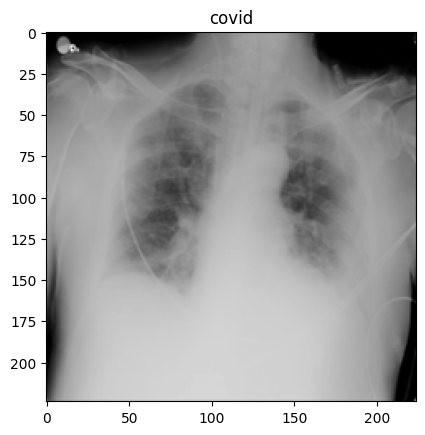

In [273]:
class LungsDataset(torch.utils.data.Dataset):
    CLASSES = 'normal', 'lung_opacity', 'viral_pneumonia', 'covid'
    def __init__(self, ann_path, transforms=None):
        self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
        self.labels = [self.CLASSES.index(lb) for lb in self.labels]
        self.transforms = transforms
    
    def _load_anns(self, ann_path):
        with open(ann_path) as fid:
            return zip(*(line.rstrip().split(',') for line in fid))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
        img = np.array(Image.open(img_path))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = np.array(Image.open(mask_path))
        
        sample = {
            'image': img,
            'mask': mask,
        }
        if self.transforms:
            sample = self.transforms(**sample)
        sample['label'] = label
        sample['image'] = sample['image'][np.newaxis]
        sample['mask'] = (sample['mask'] / 255)[np.newaxis]
        return sample

    def get_labels(self):
        # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
        return self.labels
    

train_dst = LungsDataset(DATA_PATH / 'train.csv', data_transforms['train'])
sample = train_dst[0]
plt.imshow(sample['image'][0], cmap='gray')
plt.title(train_dst.CLASSES[sample['label']])
# val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])

In [274]:
from torchsampler import ImbalancedDatasetSampler


def get_dataloaders(batch_size=16, use_sampler=True, shuffle_test=True):
    train_data = LungsDataset(DATA_PATH / 'train.csv', data_transforms['train'])
    train_sampler = ImbalancedDatasetSampler(train_data) if use_sampler else None

    test_data = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])
    
    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, shuffle=train_sampler is None, 
                                               batch_size=batch_size, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader


train_loader, test_loader = get_dataloaders()
batch = next(iter(train_loader))

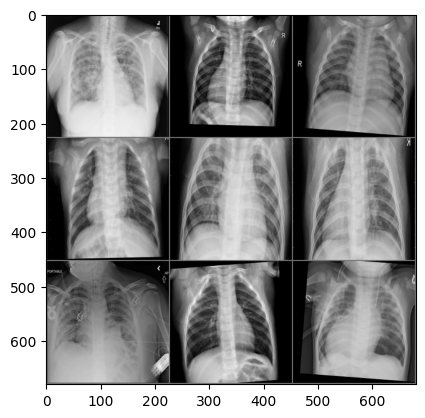

In [275]:
def imshow(inp, size=(30, 30), title=None, ax=None):
    inp = inp * grayscale_std + grayscale_mean
    inp = inp.numpy().transpose((1, 2, 0))
    if ax is None:
        plt.figure(figsize=size)
        plt.imshow(inp, ax=ax)
    ax.imshow(inp)
    if title is not None:
        plt.title(title, size=30)

batch = next(iter(train_loader))
out = torchvision.utils.make_grid(batch['image'][:9], nrow=3)
imshow(out, ax=plt.gca())


In [276]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [277]:
torch.cuda.empty_cache()

In [278]:
def get_model(pretrained=True):
    model = models.resnet18(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
#     in_conv = model.features.conv0
    in_conv = model.conv1
    # reset input layer to accept grayscale images
    model.conv1 = torch.nn.Conv2d(1, in_conv.out_channels, in_conv.kernel_size, in_conv.stride, 
                                  in_conv.padding, in_conv.dilation, in_conv.groups, in_conv.bias, in_conv.padding_mode)
    model.conv1.weight.data.copy_(in_conv.weight.mean(dim=1, keepdims=True))
    if in_conv.bias is not None:
        model.conv1.bias.data.copy_(in_conv.bias )

    # reset the classification layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(LungsDataset.CLASSES))
    model = model.to(device)
    return model

In [279]:
from sklearn.metrics import classification_report


def train_epoch(loader, model, criterion, optimizer, report=False):
    model.train()
    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='train', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
#         preds = (outputs > 0).byte()
#         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
#         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    if report:
        report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
        print(report)
    return current_loss / len(loader)
        

@torch.no_grad()
def validation_epoch(loader, model, criterion):
    model.eval()

    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='val', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
#         preds = (outputs > 0).byte()
#         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        # We want variables to hold the loss statistics
        current_loss += loss.item()
#         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    
    report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
    print('Validation report:')
    print(report)
    return current_loss / len(loader)


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        train_epoch_loss = train_epoch(dataloaders['train'], model, criterion, optimizer)
        print('Epoch {}. Train Loss: {:.4f}'.format(epoch+1, train_epoch_loss))
        
        val_epoch_loss = validation_epoch(dataloaders['val'], model, criterion)
        print('Epoch {}. Validation Loss: {:.4f}'.format(epoch+1, val_epoch_loss))
        
        scheduler.step()
        print('LR:', optimizer.param_groups[0]['lr'])

        if val_epoch_loss < best_loss:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, val_epoch_loss))
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [280]:
from collections import Counter
train_labels = np.array(train_loader.dataset.labels)

counts = Counter(train_labels)
print(counts)
class_weights = torch.zeros(len(counts)).to(device)
for c, v in counts.items():
    class_weights[c] = 1.0 - v / len(train_labels)
class_weights
# num_covid = sum(train_labels)
# num_normal = len(train_labels) - num_covid
# class_weights = torch.tensor((1 - num_normal / len(train_labels), 1 - num_covid / len(train_labels))).to(device)
# class_weights

Counter({0: 510, 1: 301, 3: 181, 2: 68})


tensor([0.5189, 0.7160, 0.9358, 0.8292], device='cuda:0')

In [281]:
np.random.seed(777)
torch.manual_seed(777)

dataloaders = {'train': train_loader, 'val': test_loader}

model = get_model(pretrained=True)
# criterion = nn.BCEWithLogitsLoss() 
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.5)
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=8)

Number of trainable parameters: 11172292
Epoch 1/8
----------


C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.5230


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.61      0.73      9682
   lung_opacity       0.87      0.72      0.79      5711
viral_pneumonia       0.97      0.88      0.92      1277
          covid       0.42      0.96      0.59      3435

       accuracy                           0.72     20105
      macro avg       0.79      0.79      0.76     20105
   weighted avg       0.82      0.72      0.73     20105

Epoch 1. Validation Loss: 0.6439
LR: 0.0001
Val loss Decreased from inf to 0.6439 
Saving Weights... 

Epoch 2/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.2244


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.86      0.91      0.88      9682
   lung_opacity       0.82      0.85      0.84      5711
viral_pneumonia       0.95      0.92      0.94      1277
          covid       0.91      0.73      0.81      3435

       accuracy                           0.86     20105
      macro avg       0.89      0.85      0.87     20105
   weighted avg       0.86      0.86      0.86     20105

Epoch 2. Validation Loss: 0.4289
LR: 0.0001
Val loss Decreased from 0.6439 to 0.4289 
Saving Weights... 

Epoch 3/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.1945


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.87      0.56      0.68      9682
   lung_opacity       0.52      0.96      0.67      5711
viral_pneumonia       0.99      0.79      0.88      1277
          covid       0.92      0.62      0.74      3435

       accuracy                           0.70     20105
      macro avg       0.82      0.73      0.74     20105
   weighted avg       0.79      0.70      0.70     20105

Epoch 3. Validation Loss: 0.7193
LR: 5e-05

Epoch 4/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.1147


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.87      0.88      9682
   lung_opacity       0.84      0.84      0.84      5711
viral_pneumonia       0.95      0.91      0.93      1277
          covid       0.79      0.89      0.84      3435

       accuracy                           0.87     20105
      macro avg       0.87      0.88      0.87     20105
   weighted avg       0.87      0.87      0.87     20105

Epoch 4. Validation Loss: 0.3612
LR: 5e-05
Val loss Decreased from 0.4289 to 0.3612 
Saving Weights... 

Epoch 5/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.1318


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.79      0.85      9682
   lung_opacity       0.71      0.92      0.80      5711
viral_pneumonia       0.97      0.88      0.93      1277
          covid       0.88      0.82      0.85      3435

       accuracy                           0.84     20105
      macro avg       0.87      0.85      0.86     20105
   weighted avg       0.85      0.84      0.84     20105

Epoch 5. Validation Loss: 0.3997
LR: 2.5e-05

Epoch 6/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.0841


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.89      0.90      0.90      9682
   lung_opacity       0.83      0.88      0.86      5711
viral_pneumonia       0.98      0.88      0.93      1277
          covid       0.92      0.82      0.87      3435

       accuracy                           0.88     20105
      macro avg       0.91      0.87      0.89     20105
   weighted avg       0.88      0.88      0.88     20105

Epoch 6. Validation Loss: 0.3450
LR: 2.5e-05
Val loss Decreased from 0.3612 to 0.3450 
Saving Weights... 

Epoch 7/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.0758


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.87      0.89      9682
   lung_opacity       0.81      0.89      0.85      5711
viral_pneumonia       0.98      0.88      0.93      1277
          covid       0.88      0.86      0.87      3435

       accuracy                           0.88     20105
      macro avg       0.89      0.88      0.88     20105
   weighted avg       0.88      0.88      0.88     20105

Epoch 7. Validation Loss: 0.3385
LR: 2.5e-05
Val loss Decreased from 0.3450 to 0.3385 
Saving Weights... 

Epoch 8/8
----------


train:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.0736


val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.93      0.79      0.86      9682
   lung_opacity       0.73      0.93      0.81      5711
viral_pneumonia       0.98      0.88      0.93      1277
          covid       0.88      0.87      0.87      3435

       accuracy                           0.85     20105
      macro avg       0.88      0.87      0.87     20105
   weighted avg       0.87      0.85      0.85     20105

Epoch 8. Validation Loss: 0.3834
LR: 2.5e-05

Training complete in 10m 24s
Best val loss: 0.3385


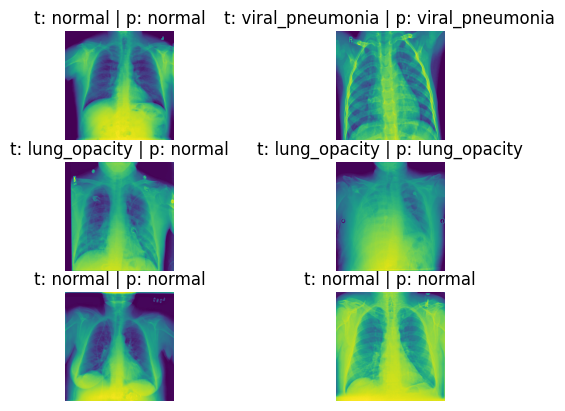

In [292]:
@torch.no_grad()
def visualize_model(model, num_images=6):
    model.eval()
    images_handled = 0
    ax = plt.figure()
    
    classes = LungsDataset.CLASSES
    for i, batch in enumerate(dataloaders['val']):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)

        outputs = model(inputs)
#         preds = (outputs > 0).byte().squeeze(1)
        preds = outputs.argmax(1)

        for j in range(inputs.size()[0]):
            images_handled += 1    
            ax = plt.subplot(num_images//2, 2, images_handled)
            ax.axis('off')
            ax.set_title('t: {} | p: {}'.format(classes[labels[j].item()], classes[preds[j]]))
            imshow(inputs.cpu()[j], (5, 5), ax=ax)

            if images_handled == num_images:
                return


visualize_model(model)
plt.show()

In [294]:
torch.save(model.state_dict(), 'resnet18_multiclass_pretrain.pth')
validation_epoch(test_loader, model, criterion)

val:   0%|          | 0/1257 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.87      0.89      9682
   lung_opacity       0.81      0.89      0.85      5711
viral_pneumonia       0.98      0.88      0.93      1277
          covid       0.88      0.86      0.87      3435

       accuracy                           0.88     20105
      macro avg       0.89      0.88      0.88     20105
   weighted avg       0.88      0.88      0.88     20105



0.3372844335731999

In [297]:
@torch.no_grad()
def predict_probs(loader, model):
    model.eval()
    probs = []
    classes = []
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
#         preds = outputs.sigmoid().squeeze(1)
        preds = outputs.softmax(1)
        probs.extend(preds.cpu().numpy())
        classes.extend(labels.cpu().numpy())
    return probs, classes
       

_, test_loader = get_dataloaders(use_sampler=False, batch_size=32, shuffle_test=False)
probs, classes = predict_probs(test_loader, model)

  0%|          | 0/629 [00:00<?, ?it/s]

[10227  1448  8430]
[13291  1214  5600]
[18920    81  1104]
[16444   669  2992]


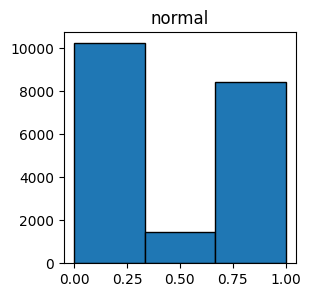

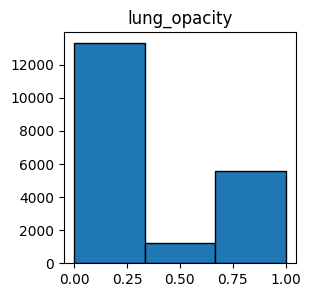

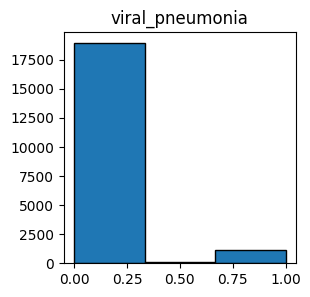

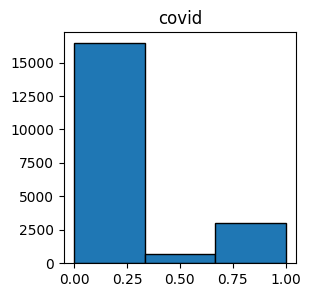

In [303]:
for explain_class in range(len(LungsDataset.CLASSES)):
    pbs = [item[explain_class] for item in probs]
    hist, bins = np.histogram(pbs, range=(0, 1), bins=3)
    plt.figure(figsize=(3, 3))
    plt.hist(pbs, bins=bins, edgecolor='black')
    plt.title(LungsDataset.CLASSES[explain_class])
    print(hist)

(array([9682., 5711., 1277., 3435.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

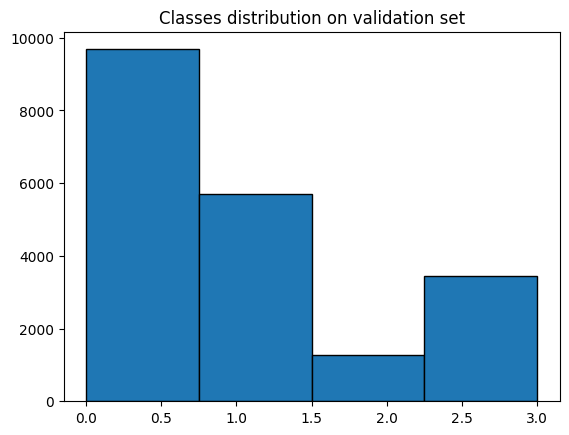

In [305]:
plt.title('Classes distribution on validation set')
plt.hist(classes, bins=len(LungsDataset.CLASSES), edgecolor='black')
